# Nutrient Limiation


In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy

In [2]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [3]:
print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

What is the new file? (new_file)


 GNG595


What year? (year)


 20yrclim


In [4]:
## Jessica's Path 
jluo_path = '/glade/scratch/jluo/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
path_file = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## Gaby's Path 
gabyn_path = '/glade/scratch/gabyn/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## 10 year climatology from year 53 - 62 representing Jan 2000-Dec 2009
new_path = '/glade/scratch/jluo/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

In [5]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [6]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim/*', recursive=True),
                      key=numericalSort)

In [7]:
# open dataset 
ds = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

## Calcualte the temperature limiation term! 
$$r = r_o e^{\frac{-E_a(T_o -T)}{k T_o T}}$$
$$\frac{\mu}{\mu_o} = e^{\frac{-E_a(T_o -T)}{k T_o T}}$$ 

to simplify however, we will create $\alpha = \frac{E_a}{k}$ and $\gamma_T = 
\frac{\mu}{\mu_o}$ so that: 
$$\gamma_T = e^{ \frac{-\alpha(T_o - T)}{T_o T}}$$

$T_o = 298.15 ^oK$
* it is close to the temperature at which many physiological experiments are run, and it is the mean temperature of the subtropical gyres, which represent a large proportion of the world’s open oceans.

$k = 8.617e^{-5} eVK^{-1}$ 

$E_a = 0.317$ phytoplankton (Kremer et al., 2017).

$E_a = 0.42$ picoplankton 
* Multiple studies have shown that picoplankton have a higher temperature sensitivity compared to phytoplankton of larger sizes (Chen et al., 2014; Stawiarski et al., 2016).

$E_a = 0.65$ zooplankton 
* MTE predicts that heterotrophic organisms will have a greater temperature dependence than autotrophs, as Rubisco carboxylation (rate limiting for photosynthesis) has a lower activation energy (Ea) than ATP synthesis (Allen et al., 2005; Lopez-Urrutia et al., 2006).

and we will have to convert all the surface temperatures from $^oC$ to $K$ and the temperature on the equation and then solve for every gorup... 
$$0°C + 273.15 = 273.15K$$

In [8]:
# convert celcius to kelvin 
temp_K = ds.TEMP + 273.15

# constants 
𝑘=8.617e-5
𝐸𝑎_phyto = 0.32 
𝐸𝑎_pico  = 0.42
𝐸𝑎_zoo   = 0.65
𝑇𝑜 = 293.15

# create simpler variables. 
𝛼_phyto = 𝐸𝑎_phyto/𝑘
𝛼_pico = 𝐸𝑎_pico/𝑘
𝛼_zoo = 𝐸𝑎_zoo/𝑘

# calculate temperature limitation term
𝛾𝑇_phyto = np.exp((-𝛼_phyto*(𝑇𝑜-temp_K))/(𝑇𝑜*temp_K))
𝛾𝑇_pico = np.exp((-𝛼_pico*(𝑇𝑜-temp_K))/(𝑇𝑜*temp_K))
𝛾𝑇_zoo = np.exp((-𝛼_zoo*(𝑇𝑜-temp_K))/(𝑇𝑜*temp_K))

### Picoplankton

In [9]:
ds.pp_light_lim_Cweight_avg_100m.shape

(12, 384, 320)

In [10]:
pp_lims=np.stack([np.nanmean(ds.pp_light_lim_Cweight_avg_100m, axis=0), 
                  np.nanmean(𝛾𝑇_phyto[:,0,:,:], axis=0),
                  np.nanmean(ds.pp_Fe_lim_Cweight_avg_100m, axis=0),
                  np.nanmean(ds.pp_P_lim_Cweight_avg_100m, axis=0),
                  np.nanmean(ds.pp_N_lim_Cweight_avg_100m, axis=0)],axis=2)

pp_lims_value=deepcopy(np.amin(pp_lims,axis=2))
pp_lims_index=deepcopy(np.argmin(pp_lims,axis=2))
        
ds['pp_lims_value']=xr.DataArray(data=pp_lims_value, dims=['nlat','nlon'], 
                                 attrs={'long_name':'Picoplankton maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['pp_lims_index']=xr.DataArray(data=pp_lims_index, dims=['nlat','nlon'], 
                                 attrs={'long_name':'Picoplankton maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-light, 1-temp, 2-Fe, 3-P, 4-N'})

### Diazotroph

In [11]:
diaz_lims=np.stack([np.nanmean(ds.diaz_light_lim_surf, axis=0), 
                    np.nanmean(𝛾𝑇_phyto[:,0,:,:], axis=0),
                    np.nanmean(ds.diaz_Fe_lim_Cweight_avg_100m, axis=0),
                    np.nanmean(ds.diaz_P_lim_Cweight_avg_100m, axis=0)],axis=2)

diaz_lims_value=deepcopy(np.amin(diaz_lims,axis=2))
diaz_lims_index=deepcopy(np.argmin(diaz_lims,axis=2))
        
ds['diaz_lims_value']=xr.DataArray(data=diaz_lims_value, dims=['nlat','nlon'], 
                                 attrs={'long_name':'Diazotroph maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['diaz_lims_index']=xr.DataArray(data=diaz_lims_index, dims=['nlat','nlon'], 
                                 attrs={'long_name':'Diazotroph maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-light, 1-temp, 2-P, 3-Fe'})

### Mixed phytoplankton

In [12]:
mp1_lim=np.stack([np.nanmean(ds.mp1_light_lim_surf, axis=0), 
                   np.nanmean(𝛾𝑇_phyto[:,0,:,:], axis=0),
                   np.nanmean(ds.mp1_Fe_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp1_P_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp1_N_lim_Cweight_avg_100m, axis=0)],axis=2)

mp1_lim_value=deepcopy(np.amin(mp1_lim,axis=2))
mp1_lim_index=deepcopy(np.argmin(mp1_lim,axis=2))
        
ds['mp1_lim_value']=xr.DataArray(data=mp1_lim_value, dims=['nlat','nlon'], 
                                 attrs={'long_name':'mp1 maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['mp1_lim_index']=xr.DataArray(data=mp1_lim_index, dims=['nlat','nlon'], 
                                 attrs={'long_name':'mp1 maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-light,1-temp, 2-P, 3-Fe, 4-N'})

mp2_lim=np.stack([np.nanmean(ds.mp2_light_lim_surf, axis=0), 
                   np.nanmean(𝛾𝑇_phyto[:,0,:,:], axis=0),
                   np.nanmean(ds.mp2_Fe_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp2_P_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp2_N_lim_Cweight_avg_100m, axis=0)],axis=2)
mp2_lim_value=deepcopy(np.amin(mp2_lim,axis=2))
mp2_lim_index=deepcopy(np.argmin(mp2_lim,axis=2))
        
ds['mp2_lim_value']=xr.DataArray(data=mp2_lim_value, dims=['nlat','nlon'], 
                                 attrs={'long_name':'mp2 maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['mp2_lim_index']=xr.DataArray(data=mp2_lim_index, dims=['nlat','nlon'], 
                                 attrs={'long_name':'mp2 maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-light,1-temp, 2-P, 3-Fe, 4-N'})

mp3_lim=np.stack([np.nanmean(ds.mp3_light_lim_surf, axis=0), 
                   np.nanmean(𝛾𝑇_phyto[:,0,:,:], axis=0),
                   np.nanmean(ds.mp3_Fe_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp3_P_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp3_N_lim_Cweight_avg_100m, axis=0)],axis=2)
mp3_lim_value=deepcopy(np.amin(mp3_lim,axis=2))
mp3_lim_index=deepcopy(np.argmin(mp3_lim,axis=2))
        
ds['mp3_lim_value']=xr.DataArray(data=mp3_lim_value,  dims=['nlat','nlon'], 
                                 attrs={'long_name':'mp3 maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['mp3_lim_index']=xr.DataArray(data=mp3_lim_index, dims=['nlat','nlon'], 
                                 attrs={'long_name':'mp3 maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-light,1-temp, 2-P, 3-Fe, 4-N'})

mp4_lim=np.stack([np.nanmean(ds.mp4_light_lim_surf, axis=0), 
                   np.nanmean(𝛾𝑇_phyto[:,0,:,:], axis=0),
                   np.nanmean(ds.mp4_Fe_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp4_P_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp4_N_lim_Cweight_avg_100m, axis=0)],axis=2)
mp4_lim_value=deepcopy(np.amin(mp4_lim,axis=2))
mp4_lim_index=deepcopy(np.argmin(mp4_lim,axis=2))
        
ds['mp4_lim_value']=xr.DataArray(data=mp4_lim_value,dims=['nlat','nlon'], 
                                 attrs={'long_name':'mp4 maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['mp4_lim_index']=xr.DataArray(data=mp4_lim_index,  dims=['nlat','nlon'], 
                                 attrs={'long_name':'mp4 maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-light,1-temp, 2-P, 3-Fe, 4-N'})

### Diatoms

In [13]:
diat1_lims=np.stack([np.nanmean(ds.diat1_light_lim_surf, axis=0), 
                     np.nanmean(𝛾𝑇_phyto[:,0,:,:], axis=0),
                     np.nanmean(ds.diat1_Fe_lim_Cweight_avg_100m, axis=0),
                     np.nanmean(ds.diat1_P_lim_Cweight_avg_100m, axis=0),
                     np.nanmean(ds.diat1_N_lim_Cweight_avg_100m, axis=0),
                     np.nanmean(ds.diat1_SiO3_lim_Cweight_avg_100m, axis=0),],axis=2)
diat1_lim_value=deepcopy(np.amin(diat1_lims,axis=2))
diat1_lim_index=deepcopy(np.argmin(diat1_lims,axis=2))
        
ds['diat1_lim_value']=xr.DataArray(data=diat1_lim_value, dims=['nlat','nlon'], 
                                 attrs={'long_name':'diatom 1 maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['diat1_lim_index']=xr.DataArray(data=diat1_lim_index,  dims=['nlat','nlon'], 
                                 attrs={'long_name':'diatom 1 maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-light,1-temp, 2-Fe, 3-P, 4-N, 5-SiO3'})
diat2_lims=np.stack([np.nanmean(ds.diat2_light_lim_surf, axis=0), 
                     np.nanmean(𝛾𝑇_phyto[:,0,:,:], axis=0),
                     np.nanmean(ds.diat2_Fe_lim_Cweight_avg_100m, axis=0),
                     np.nanmean(ds.diat2_P_lim_Cweight_avg_100m, axis=0),
                     np.nanmean(ds.diat2_N_lim_Cweight_avg_100m, axis=0),
                     np.nanmean(ds.diat2_SiO3_lim_Cweight_avg_100m, axis=0)],axis=2)

diat2_lim_value=deepcopy(np.amin(diat2_lims,axis=2))
diat2_lim_index=deepcopy(np.argmin(diat2_lims,axis=2))
        
ds['diat2_lim_value']=xr.DataArray(data=diat2_lim_value,  dims=['nlat','nlon'], 
                                 attrs={'long_name':'diatom 1 maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['diat2_lim_index']=xr.DataArray(data=diat2_lim_index, dims=['nlat','nlon'], 
                                 attrs={'long_name':'diatom 1 maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-light,1-temp, 2-Fe, 3-P, 4-N, 5-SiO3'})
diat3_lims=np.stack([np.nanmean(ds.diat3_light_lim_surf, axis=0), 
                     np.nanmean(𝛾𝑇_phyto[:,0,:,:], axis=0),
                     np.nanmean(ds.diat3_Fe_lim_Cweight_avg_100m, axis=0),
                     np.nanmean(ds.diat3_P_lim_Cweight_avg_100m, axis=0),
                     np.nanmean(ds.diat3_N_lim_Cweight_avg_100m, axis=0),
                     np.nanmean(ds.diat3_SiO3_lim_Cweight_avg_100m, axis=0)],axis=2)

diat3_lim_value=deepcopy(np.amin(diat3_lims,axis=2))
diat3_lim_index=deepcopy(np.argmin(diat3_lims,axis=2))
        
ds['diat3_lim_value']=xr.DataArray(data=diat3_lim_value, dims=['nlat','nlon'], 
                                 attrs={'long_name':'diatom 3 maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['diat3_lim_index']=xr.DataArray(data=diat3_lim_index, dims=['nlat','nlon'], 
                                 attrs={'long_name':'diatom 3 maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-light,1-temp, 2-Fe, 3-P, 4-N, 5-SiO3'})


# Solid color and just Nutrient Limitation

In [14]:
# colors for each variable 
iron        = '#FFAF47'
phosphate   = '#7B7BEE'
nitrate     = '#AECEA2'
silica      = '#F17E7E'

from matplotlib.colors import LinearSegmentedColormap
color_phyto = [iron,phosphate, nitrate]
color_diat = [iron,phosphate,nitrate,silica]
color_diaz = [iron,phosphate]

cmap_name = 'my_list'
cm_phyto = LinearSegmentedColormap.from_list(
        cmap_name, color_phyto, N=3)
cm_diaz = LinearSegmentedColormap.from_list(
        cmap_name, color_diaz, N=2)
cm_diat = LinearSegmentedColormap.from_list(
        cmap_name, color_diat, N=4)

### Picoplankton

In [25]:
pp_lims=np.stack([np.nanmean(ds.pp_P_lim_Cweight_avg_100m, axis=0),
                  np.nanmean(ds.pp_Fe_lim_Cweight_avg_100m, axis=0),
                  np.nanmean(ds.pp_N_lim_Cweight_avg_100m, axis=0)],axis=2)

pp_lims_value=deepcopy(np.amin(pp_lims,axis=2))
pp_lims_index=deepcopy(np.argmin(pp_lims,axis=2))
        
ds['pp_lims_value']=xr.DataArray(data=pp_lims_value, dims=['nlat','nlon'], 
                                 attrs={'long_name':'Picoplankton maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['pp_lims_index']=xr.DataArray(data=pp_lims_index, dims=['nlat','nlon'], 
                                 attrs={'long_name':'Picoplankton maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-Fe, 1-P, 2-N'})

### Diazotroph

In [26]:
diaz_lims=np.stack([np.nanmean(ds.diaz_P_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.diaz_Fe_lim_Cweight_avg_100m, axis=0)],axis=2)

diaz_lims_value=deepcopy(np.amin(diaz_lims,axis=2))
diaz_lims_index=deepcopy(np.argmin(diaz_lims,axis=2))
        
ds['diaz_lims_value']=xr.DataArray(data=diaz_lims_value, dims=['nlat','nlon'], 
                                 attrs={'long_name':'Diazotroph maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['diaz_lims_index']=xr.DataArray(data=diaz_lims_index, dims=['nlat','nlon'], 
                                 attrs={'long_name':'Diazotroph maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-Fe, 1-P, 2-N'})

### Mixed Phytoplankton

In [27]:
mp1_lims=np.stack([np.nanmean(ds.mp1_P_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp1_Fe_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp1_N_lim_Cweight_avg_100m, axis=0)],axis=2)

mp1_lims_value=deepcopy(np.amin(mp1_lims,axis=2))
mp1_lims_index=deepcopy(np.argmin(mp1_lims,axis=2))

ds['mp1_lims_value']=xr.DataArray(data=mp1_lims_value, dims=['nlat','nlon'], 
                                 attrs={'long_name':'mp1 maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['mp1_lims_index']=xr.DataArray(data=mp1_lims_index, dims=['nlat','nlon'], 
                                 attrs={'long_name':'mp1 maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-Fe, 1-P, 2-N'})

mp2_lims=np.stack([np.nanmean(ds.mp2_P_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp2_Fe_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp2_N_lim_Cweight_avg_100m, axis=0)],axis=2)

mp2_lims_value=deepcopy(np.amin(mp2_lims,axis=2))
mp2_lims_index=deepcopy(np.argmin(mp2_lims,axis=2))

ds['mp2_lims_value']=xr.DataArray(data=mp2_lims_value, dims=['nlat','nlon'], 
                                 attrs={'long_name':'mp2 maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['mp2_lims_index']=xr.DataArray(data=mp2_lims_index, dims=['nlat','nlon'], 
                                 attrs={'long_name':'mp2 maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-Fe, 1-P, 2-N'})

mp3_lims=np.stack([np.nanmean(ds.mp3_P_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp3_Fe_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp3_N_lim_Cweight_avg_100m, axis=0)],axis=2)

mp3_lims_value=deepcopy(np.amin(mp3_lims,axis=2))
mp3_lims_index=deepcopy(np.argmin(mp3_lims,axis=2))

ds['mp3_lims_value']=xr.DataArray(data=mp3_lims_value, dims=['nlat','nlon'], 
                                 attrs={'long_name':'mp3 maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['mp3_lims_index']=xr.DataArray(data=mp3_lims_index, dims=['nlat','nlon'], 
                                 attrs={'long_name':'mp3 maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-Fe, 1-P, 2-N'})

mp4_lims=np.stack([np.nanmean(ds.mp4_P_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp4_Fe_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp4_N_lim_Cweight_avg_100m, axis=0)],axis=2)

mp4_lims_value=deepcopy(np.amin(mp4_lims,axis=2))
mp4_lims_index=deepcopy(np.argmin(mp4_lims,axis=2))

ds['mp4_lims_value']=xr.DataArray(data=mp4_lims_value, dims=['nlat','nlon'], 
                                 attrs={'long_name':'mp4 maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['mp4_lims_index']=xr.DataArray(data=mp4_lims_index, dims=['nlat','nlon'], 
                                 attrs={'long_name':'mp4 maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-Fe, 1-P, 2-N'})


### Diatoms

In [28]:
diat1_lims=np.stack([np.nanmean(ds.diat1_P_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.diat1_Fe_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.diat1_N_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.diat1_SiO3_lim_Cweight_avg_100m, axis=0)],axis=2)

diat1_lims_value=deepcopy(np.amin(diat1_lims,axis=2))
diat1_lims_index=deepcopy(np.argmin(diat1_lims,axis=2))
        
ds['diat1_lims_value']=xr.DataArray(data=diat1_lims_value, dims=['nlat','nlon'], 
                                 attrs={'long_name':'diatom 1 maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['diat1_lims_index']=xr.DataArray(data=diat1_lims_index,dims=['nlat','nlon'], 
                                 attrs={'long_name':'diatom 1 maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-Fe, 1-P, 2-N, 3-Si'})

diat2_lims=np.stack([np.nanmean(ds.diat2_P_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.diat2_Fe_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.diat2_N_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.diat2_SiO3_lim_Cweight_avg_100m, axis=0)],axis=2)

diat2_lims_value=deepcopy(np.amin(diat2_lims,axis=2))
diat2_lims_index=deepcopy(np.argmin(diat2_lims,axis=2))
        
ds['diat2_lims_value']=xr.DataArray(data=diat2_lims_value, dims=['nlat','nlon'], 
                                 attrs={'long_name':'diatom 1 maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['diat2_lims_index']=xr.DataArray(data=diat2_lims_index, dims=['nlat','nlon'], 
                                 attrs={'long_name':'diatom 1 maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-Fe, 1-P, 2-N, 3-Si'})

diat3_lims=np.stack([np.nanmean(ds.diat3_P_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.diat3_Fe_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.diat3_N_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.diat3_SiO3_lim_Cweight_avg_100m, axis=0)],axis=2)

diat3_lims_value=deepcopy(np.amin(diat3_lims,axis=2))
diat3_lims_index=deepcopy(np.argmin(diat3_lims,axis=2))
        
ds['diat3_lims_value']=xr.DataArray(data=diat3_lims_value, dims=['nlat','nlon'], 
                                 attrs={'long_name':'diatom 3 maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['diat3_lims_index']=xr.DataArray(data=diat3_lims_index, dims=['nlat','nlon'], 
                                 attrs={'long_name':'diatom 3 maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-Fe, 1-P, 2-N, 3-Si'})

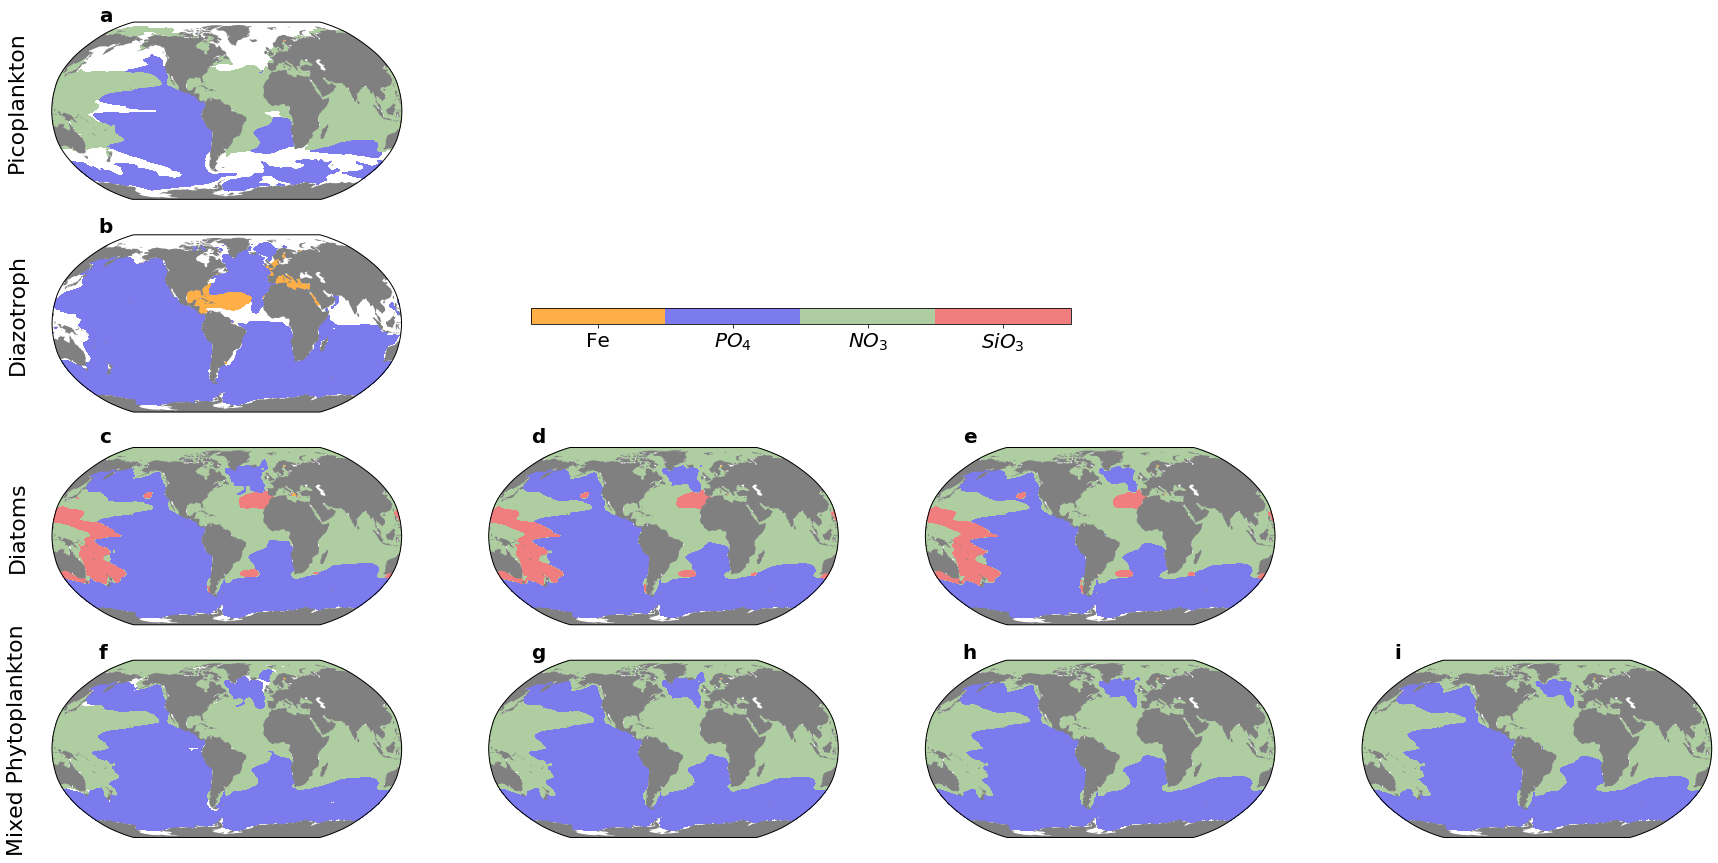

In [19]:
fig = plt.figure(figsize=(30, 15))


## Picoplanktin
lev = (0,1,2,3,4)
phyto_lims_plot = (ds.pp_lims_value.where(ds.pp_lims_value < 0.9) + ds.pp_lims_index.where(ds.pp_lims_value < 0.9))
tlon, tlat, vals = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_lims_plot)
ax = fig.add_subplot(4, 4, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon,tlat,vals, vmin=0, vmax=3,cmap=cm_phyto,levels= lev,transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.text(-0.07, 0.55, 'Picoplankton', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize = 22,
        transform=ax.transAxes)
fig.text(0.15, 0.88, 'a',fontsize=20, fontweight='bold')

## Diazotrophs
lev = (0,1,2,3)
phyto_lims_plot = (ds.diaz_lims_value.where(ds.diaz_lims_value < 0.9) + ds.diaz_lims_index.where(ds.diaz_lims_value < 0.9))
tlon, tlat, vals = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_lims_plot)
ax = fig.add_subplot(4, 4, 5, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon,tlat,vals, vmin=0, vmax=2,cmap=cm_diaz,levels= lev,transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.text(-0.07, 0.55, 'Diazotroph', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize = 22,
        transform=ax.transAxes)
fig.text(0.15, 0.685, 'b',fontsize=20, fontweight='bold')

## Diatoms
lev = (0,1,2,3,4)
diat1_lim = (ds.diat1_lims_value.where(ds.diat1_lim_value < 0.9) + ds.diat1_lims_index.where(ds.diat1_lims_value < 0.9))
tlon, tlat, diat1 = adjust_pop_grid(ds.TLONG, ds.TLAT, diat1_lim)
ax = fig.add_subplot(4, 4, 9, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon,tlat,diat1,cmap=cm_diat, vmin=0, vmax=4,levels=lev,transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.text(-0.07, 0.55, 'Diatoms', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize = 22,
        transform=ax.transAxes)
fig.text(0.15, 0.49, 'c',fontsize=20, fontweight='bold')

diat2_lim = (ds.diat2_lims_value.where(ds.diat2_lims_value < 0.9) + ds.diat2_lims_index.where(ds.diat2_lims_value < 0.9))
tlon, tlat, diat2 = adjust_pop_grid(ds.TLONG, ds.TLAT, diat2_lim)
ax2 = fig.add_subplot(4, 4, 10, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax2.contourf(tlon,tlat,diat2,cmap=cm_diat, vmin=0, vmax=4,levels=lev,transform=ccrs.PlateCarree());
land = ax2.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
fig.text(0.35, 0.49, 'd',fontsize=20, fontweight='bold')

diat3_lim = (ds.diat3_lims_value.where(ds.diat3_lims_value < 0.9) + ds.diat3_lims_index.where(ds.diat3_lims_value < 0.9))
tlon, tlat, diat3 = adjust_pop_grid(ds.TLONG, ds.TLAT, diat3_lim)
ax3 = fig.add_subplot(4, 4, 11, projection=ccrs.Robinson(central_longitude=305.0))
cf1 = ax3.contourf(tlon,tlat,diat3,cmap=cm_diat, vmin=0, vmax=4,levels=lev,transform=ccrs.PlateCarree());
land = ax3.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
fig.text(0.55, 0.49, 'e',fontsize=20, fontweight='bold')

## Mixed phytoplankton
lev = (0,1,2,3,4)
mp1_lims = (ds.mp1_lim_value.where(ds.mp1_lims_value < 0.9) + ds.mp1_lims_index.where(ds.mp1_lims_value < 0.9))
tlon, tlat, mp1 = adjust_pop_grid(ds.TLONG, ds.TLAT, mp1_lims)
ax = fig.add_subplot(4, 4, 13, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon,tlat,mp1,cmap=cm_phyto, vmin=0, vmax=3,levels = lev,transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.text(-0.07, 0.55, 'Mixed Phytoplankton', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize = 22,
        transform=ax.transAxes)
fig.text(0.15, 0.29, 'f',fontsize=20, fontweight='bold')

mp2_lims = (ds.mp2_lims_value.where(ds.mp2_lims_value < 0.9) + ds.mp2_lims_index.where(ds.mp2_lims_value < 0.9))
tlon, tlat, mp2 = adjust_pop_grid(ds.TLONG, ds.TLAT, mp2_lims)
ax1 = fig.add_subplot(4, 4, 14, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax1.contourf(tlon,tlat,mp2,cmap=cm_phyto, vmin=0, vmax=3,levels = lev, transform=ccrs.PlateCarree());
land = ax1.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
fig.text(0.35, 0.29, 'g',fontsize=20, fontweight='bold')

mp3_lims = (ds.mp3_lims_value.where(ds.mp3_lims_value < 0.9) + ds.mp3_lims_index.where(ds.mp3_lims_value < 0.9))
tlon, tlat, mp3 = adjust_pop_grid(ds.TLONG, ds.TLAT, mp3_lims)
ax2 = fig.add_subplot(4, 4, 15, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax2.contourf(tlon,tlat,mp3,cmap=cm_phyto, vmin=0, vmax=3,levels = lev,transform=ccrs.PlateCarree());
land = ax2.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
fig.text(0.55, 0.29, 'h',fontsize=20, fontweight='bold')

mp4_lims = (ds.mp4_lims_value.where(ds.mp4_lims_value < 0.9) + ds.mp4_lims_index.where(ds.mp4_lims_value < 0.9))
tlon, tlat, mp4 = adjust_pop_grid(ds.TLONG, ds.TLAT, mp4_lims)
ax3 = fig.add_subplot(4, 4, 16, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax3.contourf(tlon,tlat,mp4,cmap=cm_phyto, vmin=0, vmax=3,levels = lev,transform=ccrs.PlateCarree());
land = ax3.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
fig.text(0.75, 0.29, 'i',fontsize=20, fontweight='bold')

# colorbar and labels
cbar_ax = fig.add_axes([0.35, 0.6, 0.25, 0.015])
cbar = fig.colorbar(cf1, cax=cbar_ax, shrink=0.25, spacing='uniform',ticks=[0.5,1.5,2.5, 3.5],orientation="horizontal")
cbar.ax.set_xticklabels(['Fe','$PO_4$','$NO_3$','$SiO_3$'],fontsize =20);
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/limiation_FG_Nutrinets'+year+'_year.jpg',dpi=1000, bbox_inches='tight')

## Create a new colorbar, color blind friendly 

# colors for each variable 
# iron 
iron        = '#a50026'
iron1       = '#d73027'
iron2       = '#f46d43'
# phosphate
phosphate   = '#081d58'
phosphate1   ='#253494'
phosphate2   ='#225ea8'
# nitrate
nitrate     = '#41b6c4'
nitrate1     ='#7fcdbb'
nitrate2     ='#c7e9b4'
# silica 
silica      = '#fdae61'
silica1      ='#fee090'
silica2      ='#ffffbf'


from matplotlib.colors import LinearSegmentedColormap
color_phyto = [iron,iron1,iron2,phosphate,phosphate1,phosphate2, nitrate,nitrate1,nitrate2]
color_diat = [iron,iron1,iron2,phosphate,phosphate1,phosphate2, nitrate,nitrate1,nitrate2,silica,silica1,silica2]
color_diaz = [iron,iron1,iron2,phosphate,phosphate1,phosphate2]

cmap_name = 'my_list'
cm_phyto = LinearSegmentedColormap.from_list(
        cmap_name, color_phyto, N=3)
cm_diaz = LinearSegmentedColormap.from_list(
        cmap_name, color_diaz, N=2)
cm_diat = LinearSegmentedColormap.from_list(
        cmap_name, color_diat, N=4)

### Colorbar 1 

# colors for each variable 
# iron 
iron        = '#1b9e77'
iron1       = '#66c2a5'
iron2       = '#99d8c9'
# phosphate
phosphate   = '#d95f02'
phosphate1   ='#fc8d62'
phosphate2   ='#fee8c8'
# nitrate
nitrate     = '#7570b3'
nitrate1     ='#8da0cb'
nitrate2     ='#e0ecf4'
# iron 
silica      = '#756bb1'
silica1      ='#bcbddc'
silica2      ='#efedf5'

### Colorbar 2 

# colors for each variable 
# iron 
iron        = '#c51b7d'
iron1       = '#de77ae'

# phosphate
phosphate   = '#f1b6da'
phosphate1   ='#fde0ef'

# nitrate
nitrate     = '#e6f5d0'
nitrate1     ='#b8e186'

# iron 
silica      = '#7fbc41'
silica1      ='#4d9221'


# colors for each variable 
# iron 
iron        = '#d73027'
iron1       = '#f46d43'

# phosphate
phosphate   = '#fdae61'
phosphate1   ='#fee090'

# nitrate
nitrate     = '#e0f3f8'
nitrate1     ='#abd9e9'

# iron 
silica      = '#74add1'
silica1      ='#4575b4'


In [35]:
# colors for each variable 
# iron 
phosphate        = '#a50026'
phosphate1       = '#d73027'
phosphate2       = '#f46d43'
# phosphate
iron   = '#fdae61'
iron1   ='#fee090'
iron2   ='#ffffbf'
# nitrate
nitrate2     = '#e0f3f8'
nitrate1     ='#abd9e9'
nitrate     ='#74add1'
# iron 
silica2      = '#4575b4'
silica1      ='#313695'
silica      ='#081d58'

### Colorbar 3 

In [36]:


from matplotlib.colors import LinearSegmentedColormap
color_iron = [iron,iron1]
color_phosphate = [phosphate,phosphate1]
color_nitrate = [nitrate,nitrate1]
color_silicate = [silica,silica1]

cmap_name = 'my_list'
cm_iron = LinearSegmentedColormap.from_list(
        cmap_name, color_iron, N=2)
cm_phosphate = LinearSegmentedColormap.from_list(
        cmap_name, color_phosphate, N=2)
cm_nitrate = LinearSegmentedColormap.from_list(
        cmap_name, color_nitrate, N=2)
cm_silicate = LinearSegmentedColormap.from_list(
        cmap_name, color_silicate, N=2)

In [37]:


from matplotlib.colors import LinearSegmentedColormap
color_iron = [iron,iron1,iron2]
color_phosphate = [phosphate,phosphate1,phosphate2]
color_nitrate = [nitrate,nitrate1,nitrate2]
color_silicate = [silica,silica1,silica2]

cmap_name = 'my_list'
cm_iron = LinearSegmentedColormap.from_list(
        cmap_name, color_iron, N=3)
cm_phosphate = LinearSegmentedColormap.from_list(
        cmap_name, color_phosphate, N=3)
cm_nitrate = LinearSegmentedColormap.from_list(
        cmap_name, color_nitrate, N=3)
cm_silicate = LinearSegmentedColormap.from_list(
        cmap_name, color_silicate, N=3)

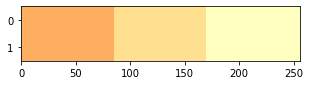

In [38]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(1,1,figsize=(5,1))
ax.imshow(gradient, aspect='auto', cmap=cm_iron)

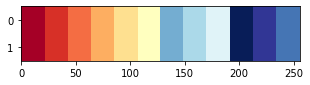

In [39]:
N = 3 # number of colors to extract from each of the base_cmaps below
phyto = [cm_phosphate,cm_iron,cm_nitrate]
diat = [cm_phosphate,cm_iron,cm_nitrate,cm_silicate]
diaz = [cm_phosphate,cm_iron]

n_base = len(phyto)
# we go from 0.2 to 0.8 below to avoid having several whites and blacks in the resulting cmaps
colors_phyto = np.concatenate([plt.get_cmap(name)(np.linspace(0,1,N)) for name in phyto])
cm_phyto = mpl.colors.ListedColormap(colors_phyto)

n_base = len(diaz)
# we go from 0.2 to 0.8 below to avoid having several whites and blacks in the resulting cmaps
colors_diaz = np.concatenate([plt.get_cmap(name)(np.linspace(0,1,N)) for name in diaz])
cm_diaz = mpl.colors.ListedColormap(colors_diaz)

n_base = len(diat)
# we go from 0.2 to 0.8 below to avoid having several whites and blacks in the resulting cmaps
colors_diat = np.concatenate([plt.get_cmap(name)(np.linspace(0,1,N)) for name in diat])
cm_diat = mpl.colors.ListedColormap(colors_diat)

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(1,1,figsize=(5,1))
ax.imshow(gradient, aspect='auto', cmap=cm_diat)

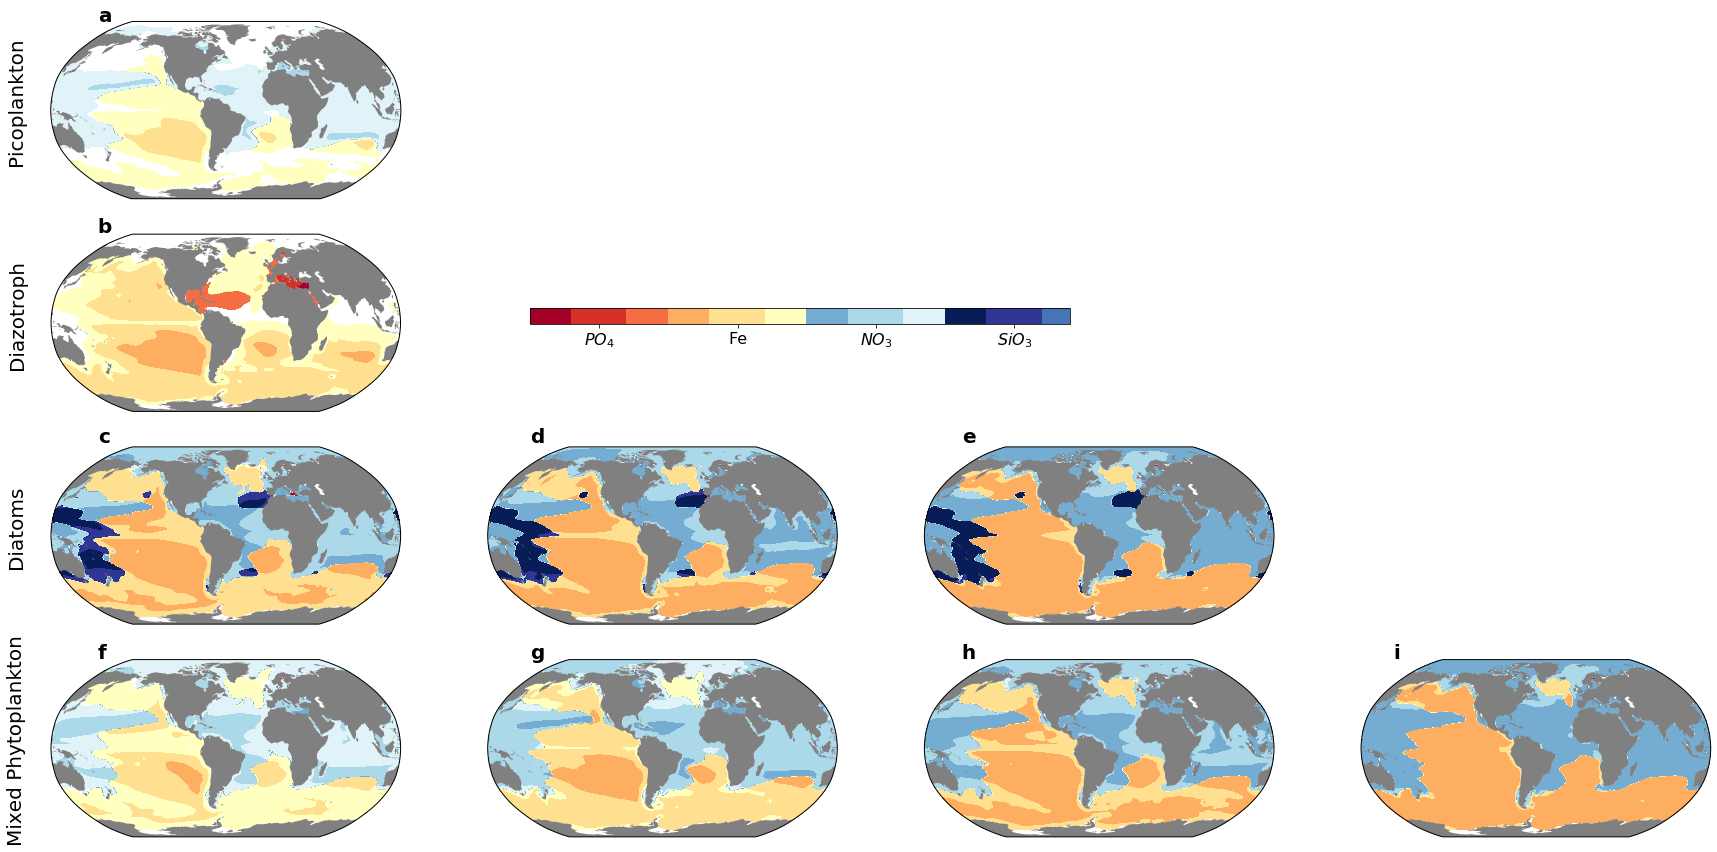

In [40]:
fig = plt.figure(figsize=(30, 15))


## Picoplanktin
lev = np.arange(0, 3, 0.1)
phyto_lims_plot = (ds.pp_lims_value.where(ds.pp_lims_value < 0.9) + ds.pp_lims_index.where(ds.pp_lims_value < 0.9))
tlon, tlat, vals = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_lims_plot)
ax = fig.add_subplot(4, 4, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon,tlat,vals, vmin=0, vmax=3,cmap=cm_phyto,levels= lev,transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.text(-0.07, 0.55, 'Picoplankton', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize = 24,
        transform=ax.transAxes)
fig.text(0.15, 0.88, 'a',fontsize=24, fontweight='bold')

## Diazotrophs
lev = np.arange(0, 2, 0.1)
phyto_lims_plot = (ds.diaz_lims_value.where(ds.diaz_lims_value < 0.9) + ds.diaz_lims_index.where(ds.diaz_lims_value < 0.9))
tlon, tlat, vals = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_lims_plot)
ax = fig.add_subplot(4, 4, 5, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon,tlat,vals, vmin=0, vmax=2,cmap=cm_diaz,levels= lev,transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.text(-0.07, 0.55, 'Diazotroph', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize = 24,
        transform=ax.transAxes)
fig.text(0.15, 0.685, 'b',fontsize=24, fontweight='bold')

## Diatoms
lev = np.arange(0, 4, 0.1)
diat1_lim = (ds.diat1_lims_value.where(ds.diat1_lims_value < 0.9) + ds.diat1_lims_index.where(ds.diat1_lims_value < 0.9))
tlon, tlat, diat1 = adjust_pop_grid(ds.TLONG, ds.TLAT, diat1_lim)
ax = fig.add_subplot(4, 4, 9, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon,tlat,diat1,cmap=cm_diat, vmin=0, vmax=4,levels=lev,transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.text(-0.07, 0.55, 'Diatoms', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize = 24,
        transform=ax.transAxes)
fig.text(0.15, 0.49, 'c',fontsize=24, fontweight='bold')

diat2_lim = (ds.diat2_lims_value.where(ds.diat2_lims_value < 0.9) + ds.diat2_lims_index.where(ds.diat2_lims_value < 0.9))
tlon, tlat, diat2 = adjust_pop_grid(ds.TLONG, ds.TLAT, diat2_lim)
ax2 = fig.add_subplot(4, 4, 10, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax2.contourf(tlon,tlat,diat2,cmap=cm_diat, vmin=0, vmax=4,levels=lev,transform=ccrs.PlateCarree());
land = ax2.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
fig.text(0.35, 0.49, 'd',fontsize=24, fontweight='bold')

diat3_lim = (ds.diat3_lims_value.where(ds.diat3_lims_value < 0.9) + ds.diat3_lims_index.where(ds.diat3_lims_value < 0.9))
tlon, tlat, diat3 = adjust_pop_grid(ds.TLONG, ds.TLAT, diat3_lim)
ax3 = fig.add_subplot(4, 4, 11, projection=ccrs.Robinson(central_longitude=305.0))
cf1 = ax3.contourf(tlon,tlat,diat3,cmap=cm_diat, vmin=0, vmax=4,levels=lev,transform=ccrs.PlateCarree());
land = ax3.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
fig.text(0.55, 0.49, 'e',fontsize=24, fontweight='bold')

## Mixed phytoplankton
lev = np.arange(0, 4, 0.1)
mp1_lims = (ds.mp1_lims_value.where(ds.mp1_lims_value < 0.9) + ds.mp1_lims_index.where(ds.mp1_lims_value < 0.9))
tlon, tlat, mp1 = adjust_pop_grid(ds.TLONG, ds.TLAT, mp1_lims)
ax = fig.add_subplot(4, 4, 13, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon,tlat,mp1,cmap=cm_phyto, vmin=0, vmax=3,levels = lev,transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.text(-0.07, 0.55, 'Mixed Phytoplankton', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize = 24,
        transform=ax.transAxes)
fig.text(0.15, 0.29, 'f',fontsize=24, fontweight='bold')

mp2_lims = (ds.mp2_lims_value.where(ds.mp2_lims_value < 0.9) + ds.mp2_lims_index.where(ds.mp2_lims_value < 0.9))
tlon, tlat, mp2 = adjust_pop_grid(ds.TLONG, ds.TLAT, mp2_lims)
ax1 = fig.add_subplot(4, 4, 14, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax1.contourf(tlon,tlat,mp2,cmap=cm_phyto, vmin=0, vmax=3,levels = lev, transform=ccrs.PlateCarree());
land = ax1.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
fig.text(0.35, 0.29, 'g',fontsize=24, fontweight='bold')

mp3_lims = (ds.mp3_lims_value.where(ds.mp3_lims_value < 0.9) + ds.mp3_lims_index.where(ds.mp3_lims_value < 0.9))
tlon, tlat, mp3 = adjust_pop_grid(ds.TLONG, ds.TLAT, mp3_lims)
ax2 = fig.add_subplot(4, 4, 15, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax2.contourf(tlon,tlat,mp3,cmap=cm_phyto, vmin=0, vmax=3,levels = lev,transform=ccrs.PlateCarree());
land = ax2.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
fig.text(0.55, 0.29, 'h',fontsize=24, fontweight='bold')

mp4_lims = (ds.mp4_lims_value.where(ds.mp4_lims_value < 0.9) + ds.mp4_lims_index.where(ds.mp4_lims_value < 0.9))
tlon, tlat, mp4 = adjust_pop_grid(ds.TLONG, ds.TLAT, mp4_lims)
ax3 = fig.add_subplot(4, 4, 16, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax3.contourf(tlon,tlat,mp4,cmap=cm_phyto, vmin=0, vmax=3,levels = lev,transform=ccrs.PlateCarree());
land = ax3.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
fig.text(0.75, 0.29, 'i',fontsize=24, fontweight='bold')

# colorbar and labels
cbar_ax = fig.add_axes([0.35, 0.6, 0.25, 0.015])
cbar = fig.colorbar(cf1, cax=cbar_ax, shrink=0.25, spacing='uniform',ticks=[0.5,1.5,2.5, 3.5],orientation="horizontal")
cbar.ax.set_xticklabels(['$PO_4$','Fe','$NO_3$','$SiO_3$'],fontsize =20);
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/limiation_Nutrinets_cl'+year+'_year.jpg',dpi=1000, bbox_inches='tight')

## Now create an average for each phytoplankton group.. 

In [30]:
diats = ['diat1','diat2','diat3']
ds['diat_Fe_lim_Cweight_avg_100m'] = xr.concat([ds['' + v + '_Fe_lim_Cweight_avg_100m'] for v in diats], dim='var').mean(dim='var')
ds['diat_P_lim_Cweight_avg_100m'] = xr.concat([ds['' + v + '_P_lim_Cweight_avg_100m'] for v in diats], dim='var').mean(dim='var')
ds['diat_N_lim_Cweight_avg_100m'] = xr.concat([ds['' + v + '_N_lim_Cweight_avg_100m'] for v in diats], dim='var').mean(dim='var')
ds['diat_SiO3_lim_Cweight_avg_100m'] = xr.concat([ds['' + v + '_SiO3_lim_Cweight_avg_100m'] for v in diats], dim='var').mean(dim='var')

In [31]:
diat_lims=np.stack([np.nanmean(ds.diat_Fe_lim_Cweight_avg_100m, axis=0),
                     np.nanmean(ds.diat_P_lim_Cweight_avg_100m, axis=0),
                     np.nanmean(ds.diat_N_lim_Cweight_avg_100m, axis=0),
                     np.nanmean(ds.diat_SiO3_lim_Cweight_avg_100m, axis=0),],axis=2)
diat_lim_value=deepcopy(np.amin(diat_lims,axis=2))
diat_lim_index=deepcopy(np.argmin(diat_lims,axis=2))
        
ds['diat_lim_value']=xr.DataArray(data=diat_lim_value, dims=['nlat','nlon'], 
                                 attrs={'long_name':'Average diatom maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['diat_lim_index']=xr.DataArray(data=diat_lim_index,  dims=['nlat','nlon'], 
                                 attrs={'long_name':'Average diatom maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-Fe, 1-P, 2-N, 3-SiO3'})

In [32]:
mixed_phyto = ['mp1', 'mp2', 'mp3','mp4']
ds['mp_Fe_lim_Cweight_avg_100m'] = xr.concat([ds['' + v + '_Fe_lim_Cweight_avg_100m'] for v in mixed_phyto], dim='var').mean(dim='var')
ds['mp_P_lim_Cweight_avg_100m'] = xr.concat([ds['' + v + '_P_lim_Cweight_avg_100m'] for v in mixed_phyto], dim='var').mean(dim='var')
ds['mp_N_lim_Cweight_avg_100m'] = xr.concat([ds['' + v + '_N_lim_Cweight_avg_100m'] for v in mixed_phyto], dim='var').mean(dim='var')

In [33]:
mp_lim=np.stack([np.nanmean(ds.mp_Fe_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp_P_lim_Cweight_avg_100m, axis=0),
                   np.nanmean(ds.mp_N_lim_Cweight_avg_100m, axis=0)],axis=2)

mp_lim_value=deepcopy(np.amin(mp_lim,axis=2))
mp_lim_index=deepcopy(np.argmin(mp_lim,axis=2))
        
ds['mp_lim_value']=xr.DataArray(data=mp_lim_value, dims=['nlat','nlon'], 
                                 attrs={'long_name':'mean mixed phyto maximum limitation value, carbon biomass weighted average over 0-100m'})
ds['mp_lim_index']=xr.DataArray(data=mp_lim_index, dims=['nlat','nlon'], 
                                 attrs={'long_name':'mean mixed phyto maximum limitation type, carbon biomass weighted average over 0-100m',
                                        'values':'0-P, 1-Fe, 2-N'})

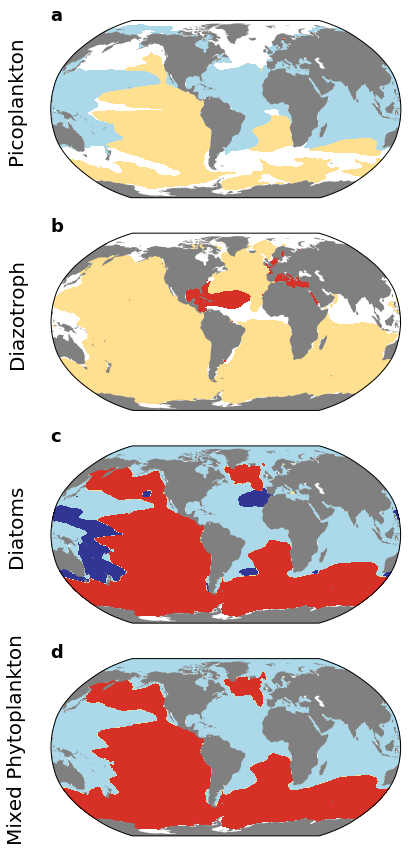

In [34]:
fig = plt.figure(figsize=(15, 15))


## Picoplanktin
lev = (0,1,2,3,4)
phyto_lims_plot = (ds.pp_lims_value.where(ds.pp_lims_value < 0.9) + ds.pp_lims_index.where(ds.pp_lims_value < 0.9))
tlon, tlat, vals = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_lims_plot)
ax = fig.add_subplot(4, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon,tlat,vals, vmin=0, vmax=3,cmap=cm_phyto,levels= lev,transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.text(-0.07, 0.55, 'Picoplankton', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize = 20,
        transform=ax.transAxes)
fig.text(0.35, 0.88, 'a',fontsize=18, fontweight='bold')

## Diazotrophs
lev = (0,1,2,3)
phyto_lims_plot = (ds.diaz_lims_value.where(ds.diaz_lims_value < 0.9) + ds.diaz_lims_index.where(ds.diaz_lims_value < 0.9))
tlon, tlat, vals = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_lims_plot)
ax = fig.add_subplot(4, 1, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon,tlat,vals, vmin=0, vmax=2,cmap=cm_diaz,levels= lev,transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.text(-0.07, 0.55, 'Diazotroph', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize = 20,
        transform=ax.transAxes)
fig.text(0.35, 0.685, 'b',fontsize=18, fontweight='bold')

## Diatoms
lev = (0,1,2,3,4)
diat1_lim = (ds.diat_lim_value.where(ds.diat_lim_value < 0.9) + ds.diat_lim_index.where(ds.diat_lim_value < 0.9))
tlon, tlat, diat1 = adjust_pop_grid(ds.TLONG, ds.TLAT, diat1_lim)
ax = fig.add_subplot(4, 1, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon,tlat,diat1,cmap=cm_diat, vmin=0, vmax=4,levels=lev,transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.text(-0.07, 0.55, 'Diatoms', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize = 20,
        transform=ax.transAxes)
fig.text(0.35, 0.49, 'c',fontsize=18, fontweight='bold')

## Mixed phytoplankton
lev = (0,1,2,3,4)
mp1_lims = (ds.mp_lim_value.where(ds.mp_lim_value < 0.9) + ds.mp_lim_index.where(ds.mp_lim_value < 0.9))
tlon, tlat, mp1 = adjust_pop_grid(ds.TLONG, ds.TLAT, mp1_lims)
ax = fig.add_subplot(4, 1, 4, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon,tlat,mp1,cmap=cm_phyto, vmin=0, vmax=3,levels = lev,transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.text(-0.07, 0.55, 'Mixed Phytoplankton', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize = 20,
        transform=ax.transAxes)
fig.text(0.35, 0.29, 'd',fontsize=18, fontweight='bold')

# colorbar and labels
#cbar_ax = fig.add_axes([0.35, 0.6, 0.25, 0.015])
cbar = fig.colorbar(cf1, cax=cbar_ax, shrink=0.25, spacing='uniform',ticks=[0.5,1.5,2.5, 3.5],orientation="horizontal")
cbar.ax.set_xticklabels(['Fe','$PO_4$','$NO_3$','$SiO_3$'],fontsize =16);
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/limiation_FG_PFT_Nutrinets'+year+'_year.jpg',dpi=1000, bbox_inches='tight')